# Framingham Heart Disease Prediction
This notebook performs feature selection, data preprocessing, and prediction using the KNN classifier.

Using fixed features: ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3751
Model:                          Logit   Df Residuals:                     3743
Method:                           MLE   Df Model:                            7
Date:                Fri, 23 May 2025   Pseudo R-squ.:                 0.09018
Time:                        18:07:51   Log-Likelihood:                -1457.3
converged:                       True   LL-Null:                       -1601.7
Covariance Type:            nonrobust   LLR p-value:                 1.434e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.8392      0.563    -13.912      0.000      -8.944      -6.735
age            0.0581      0.006      9.2

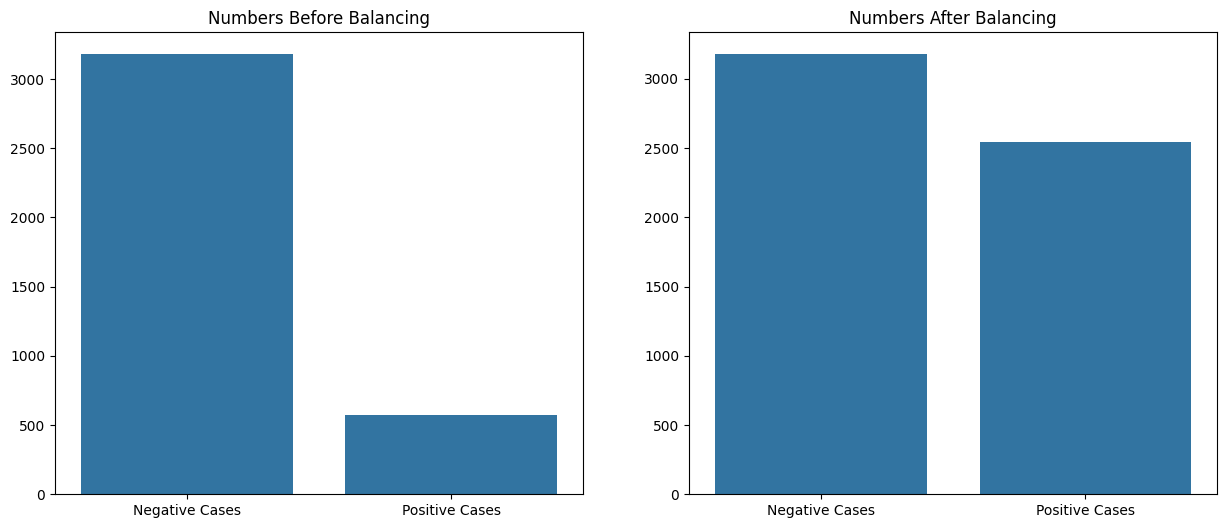

Best KNN params: {'n_neighbors': 6}
Best cross-validation accuracy: 0.7638
Calibrated KNN model fitted.
Trained Logistic Regression.

KNN Evaluation:
Accuracy on test set: 79.74%


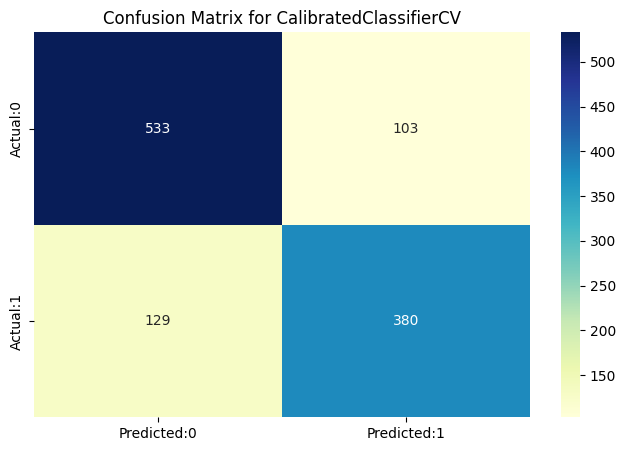


Logistic Regression Evaluation:
Accuracy on test set: 66.11%


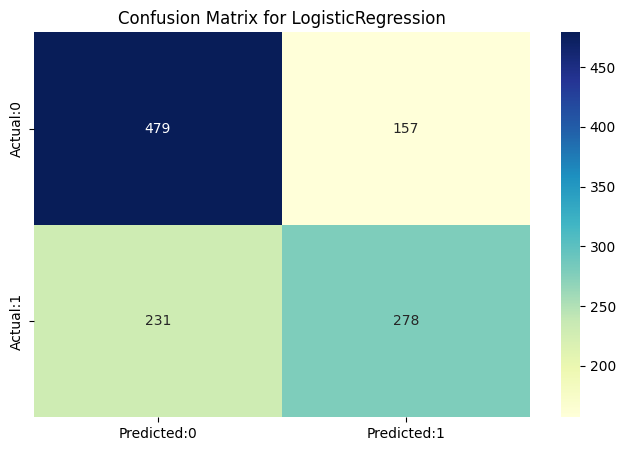

Saved models and scaler in 'models/' folder:
- knn_model.pkl
- logreg_model.pkl
- scaler.pkl
- features.json

Predictions using knn model:
Example 1: You are safe. 😊 (Confidence: 92.80%)
Example 2: Sorry, You are at risk. 👽 (Confidence: 63.49%)

Predictions using logistic_regression model:
Example 1: You are safe. 😊 (Confidence: 82.86%)
Example 2: Sorry, You are at risk. 👽 (Confidence: 70.76%)


In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
import joblib
import os
import json

warnings.filterwarnings('ignore')

def load_and_clean_data(filepath='dataset/framingham.csv'):
    data = pd.read_csv(filepath)
    data.drop(['education'], axis=1, inplace=True)
    data.dropna(axis=0, inplace=True)
    return data

def logistic_regression_summary(X, y):
    X_const = sm.add_constant(X)
    model = sm.Logit(y, X_const).fit(disp=0)
    print(model.summary())-
    conf = model.conf_int()
    conf['Odds Ratio'] = model.params
    conf.columns = ['5%', '95%', 'Odds Ratio']
    print(np.exp(conf))

def balance_data(X, y, sampling_strategy=0.8):
    over = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    under = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    pipeline = Pipeline(steps=[('o', over), ('u', under)])
    X_res, y_res = pipeline.fit_resample(X, y)
    print(f"Before resampling: {Counter(y)}")
    print(f"After resampling: {Counter(y_res)}")
    
    labels = ["Negative Cases", "Positive Cases"]
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sns.barplot(x=labels, y=list(Counter(y).values()))
    plt.title("Numbers Before Balancing")
    plt.subplot(1,2,2)
    sns.barplot(x=labels, y=list(Counter(y_res).values()))
    plt.title("Numbers After Balancing")
    plt.show()

    return X_res, y_res

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return pd.DataFrame(X_train_scaled, columns=X_train.columns), pd.DataFrame(X_test_scaled, columns=X_test.columns), scaler

def tune_and_train_knn(X_train, y_train):
    param_grid = {'n_neighbors': list(range(5, 31))}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, scoring='accuracy', cv=10, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best KNN params: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

    best_knn = grid_search.best_estimator_
    calibrated_knn = CalibratedClassifierCV(best_knn, cv=5, method='sigmoid')
    calibrated_knn.fit(X_train, y_train)
    print("Calibrated KNN model fitted.")
    return calibrated_knn

def train_logistic_regression(X_train, y_train):
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    logreg.fit(X_train, y_train)
    print("Trained Logistic Regression.")
    return logreg

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy on test set: {acc * 100:.2f}%")

    cm = confusion_matrix(y_test, y_pred)
    conf_matrix = pd.DataFrame(cm, columns=['Predicted:0', 'Predicted:1'], index=['Actual:0', 'Actual:1'])
    plt.figure(figsize=(8,5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()
    return y_pred

def predict_with_all_models(models_dict, features, samples):
    samples_df = pd.DataFrame(samples, columns=features)
    samples_scaled = models_dict['scaler'].transform(samples_df)

    for model_name, model in models_dict.items():
        if model_name in ['scaler', 'features']:
            continue  # Skip scaler and features keys

        print(f"\nPredictions using {model_name} model:")
        pred_probs = model.predict_proba(samples_scaled)
        preds = model.predict(samples_scaled)
        for i, (pred, prob) in enumerate(zip(preds, pred_probs), 1):
            confidence = prob[pred]
            confidence_percent = confidence * 100
            status = "You are safe. 😊" if pred == 0 else "Sorry, You are at risk. 👽"
            print(f"Example {i}: {status} (Confidence: {confidence_percent:.2f}%)")

# --- Main workflow starts here ---

data = load_and_clean_data()

top_features = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
print(f"Using fixed features: {top_features}")

X_top = data[top_features]
y = data['TenYearCHD']

logistic_regression_summary(X_top, y)

X_balanced, y_balanced = balance_data(X_top, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

# Train models
knn_model = tune_and_train_knn(X_train_scaled, y_train)
logreg_model = train_logistic_regression(X_train_scaled, y_train)

# Evaluate models
print("\nKNN Evaluation:")
evaluate_model(knn_model, X_test_scaled, y_test)

print("\nLogistic Regression Evaluation:")
evaluate_model(logreg_model, X_test_scaled, y_test)

# --- Save models, scaler and features separately ---

os.makedirs('models', exist_ok=True)  # Create models folder if not exists

joblib.dump(knn_model, 'models/knn_model.pkl')
joblib.dump(logreg_model, 'models/logreg_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

with open('models/features.json', 'w') as f:
    json.dump(top_features, f)

print("Saved models and scaler in 'models/' folder:")
print("- knn_model.pkl")
print("- logreg_model.pkl")
print("- scaler.pkl")
print("- features.json")

# Predict new samples with all models loaded in dictionary (for demonstration)
all_models = {
    'knn': knn_model,
    'logistic_regression': logreg_model,
    'scaler': scaler,
    'features': top_features
}

new_samples = [
    [39, 195, 106, 70, 26.97, 80, 77],
    [65, 150, 180, 70, 26.97, 80, 77]
]

predict_with_all_models(all_models, top_features, new_samples)
